In [1]:
import numpy as numpy
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
!ls

kaggle.json  sample_data


In [3]:
!mkdir kaggle
!mv kaggle.json kaggle\kaggle.json

In [4]:
!chmod 600 kaggle\kaggle.json

In [5]:
!kaggle datasets download -d muhammadardiputra/potato-leaf-disease-dataset


Dataset URL: https://www.kaggle.com/datasets/muhammadardiputra/potato-leaf-disease-dataset
License(s): unknown
 67% 17.0M/25.2M [00:00<00:00, 50.1MB/s]
100% 25.2M/25.2M [00:00<00:00, 56.5MB/s]


In [6]:
!unzip /content/potato-leaf-disease-dataset.zip

Archive:  /content/potato-leaf-disease-dataset.zip
  inflating: Potato/Test/Potato___Early_blight/034959c1-f1e8-4a79-a6d5-3c1d14efa2f3___RS_Early.B 7136.JPG  
  inflating: Potato/Test/Potato___Early_blight/042135e2-e126-4900-9212-d42d900b8125___RS_Early.B 8791.JPG  
  inflating: Potato/Test/Potato___Early_blight/0604174e-3018-4faa-9975-0be32d2c0789___RS_Early.B 7123.JPG  
  inflating: Potato/Test/Potato___Early_blight/07953ca1-8935-449f-b338-4357ed683b2d___RS_Early.B 6815.JPG  
  inflating: Potato/Test/Potato___Early_blight/08029ccc-387e-4be6-9389-04f7b82fdb2a___RS_Early.B 9130.JPG  
  inflating: Potato/Test/Potato___Early_blight/08194ca3-f0b2-4aaa-8df8-5ec5ddc6696a___RS_Early.B 8151.JPG  
  inflating: Potato/Test/Potato___Early_blight/08392b44-ecc6-4f38-8566-361b552cfe21___RS_Early.B 7393.JPG  
  inflating: Potato/Test/Potato___Early_blight/107827b3-faa5-457c-97fd-3e34d2657f6b___RS_Early.B 7162.JPG  
  inflating: Potato/Test/Potato___Early_blight/109730cd-03f3-4139-a464-5f9151483e8c__

In [7]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os


In [8]:
import os

fldr = "/content/Potato/Train"
file_list = os.listdir(fldr)

cnt = 1
max_files = 5  # Maximum number of files to print

images = []
for folder in file_list:
    next_folder = os.path.join(fldr, folder)

    # Check if it's a directory
    if os.path.isdir(next_folder):
        for file_name in os.listdir(next_folder):

                file_path = os.path.join(next_folder, file_name)

                images.append(file_path)



<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7983C511DC30>


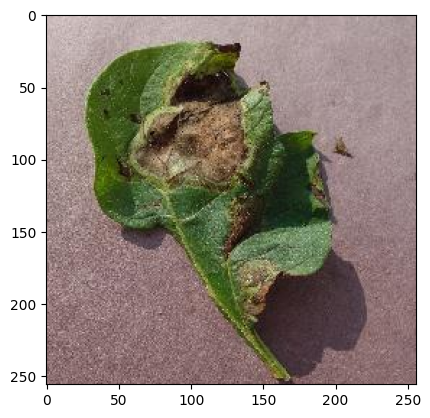

In [9]:
from PIL import Image

# Example: Path to an image file
image_path = "/content/Potato/Train/Potato___Late_blight/f3ee2886-4ada-4287-94b6-c4c93005b887___RS_LB 4352.JPG"
img = Image.open(image_path)
plt.imshow(img)
print(img)

In [10]:
df = pd.DataFrame()
df["images"] = images

In [11]:
df.head()

,images
0,/content/Potato/Train/Potato___Late_blight/f3e...
1,/content/Potato/Train/Potato___Late_blight/e10...
2,/content/Potato/Train/Potato___Late_blight/c31...
3,/content/Potato/Train/Potato___Late_blight/c4a...
4,/content/Potato/Train/Potato___Late_blight/c58...


In [12]:
print(len(df))

900


In [13]:
class_mapping = {
    'Potato___Late_blight': 0,
    'Potato___Early_blight': 1,
    'Potato___healthy': 2
}

# Extract class names and map to labels
df['class'] = df['images'].apply(lambda x: x.split('/')[4])
df['class_label'] = df['class'].map(class_mapping)


In [14]:
df['class_label'].value_counts()

class_label
0    300
2    300
1    300
Name: count, dtype: int64

In [15]:
df.head()

,images,class,class_label
0,/content/Potato/Train/Potato___Late_blight/f3e...,Potato___Late_blight,0
1,/content/Potato/Train/Potato___Late_blight/e10...,Potato___Late_blight,0
2,/content/Potato/Train/Potato___Late_blight/c31...,Potato___Late_blight,0
3,/content/Potato/Train/Potato___Late_blight/c4a...,Potato___Late_blight,0
4,/content/Potato/Train/Potato___Late_blight/c58...,Potato___Late_blight,0


In [16]:
def preprocess_image(image_path, label):
    # Read and decode an image file to a uint8 tensor
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)

    # Resize the image to the desired size
    img = tf.image.resize(img, [256, 256])

    # Normalize the image to [0, 1]
    img = img / 255.0

    return img, label


In [17]:
def create_dataset(df, batch_size=32):
    image_paths = df["images"].values
    labels = df["class_label"].values

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=len(df))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

# Create the dataset
batch_size = 32
train_dataset = create_dataset(df, batch_size)

# Inspect the dataset
for images_batch, labels_batch in train_dataset.take(1):
    print(f"Batch of images shape: {images_batch.shape}")
    print(f"Batch of labels shape: {labels_batch.shape}")


Batch of images shape: (32, 256, 256, 3)
Batch of labels shape: (32,)


In [18]:
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    return image, label

augmented_train_dataset = train_dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)


In [19]:
class_names = ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

ValueError: num must be an integer with 1 <= num <= 16, not 17

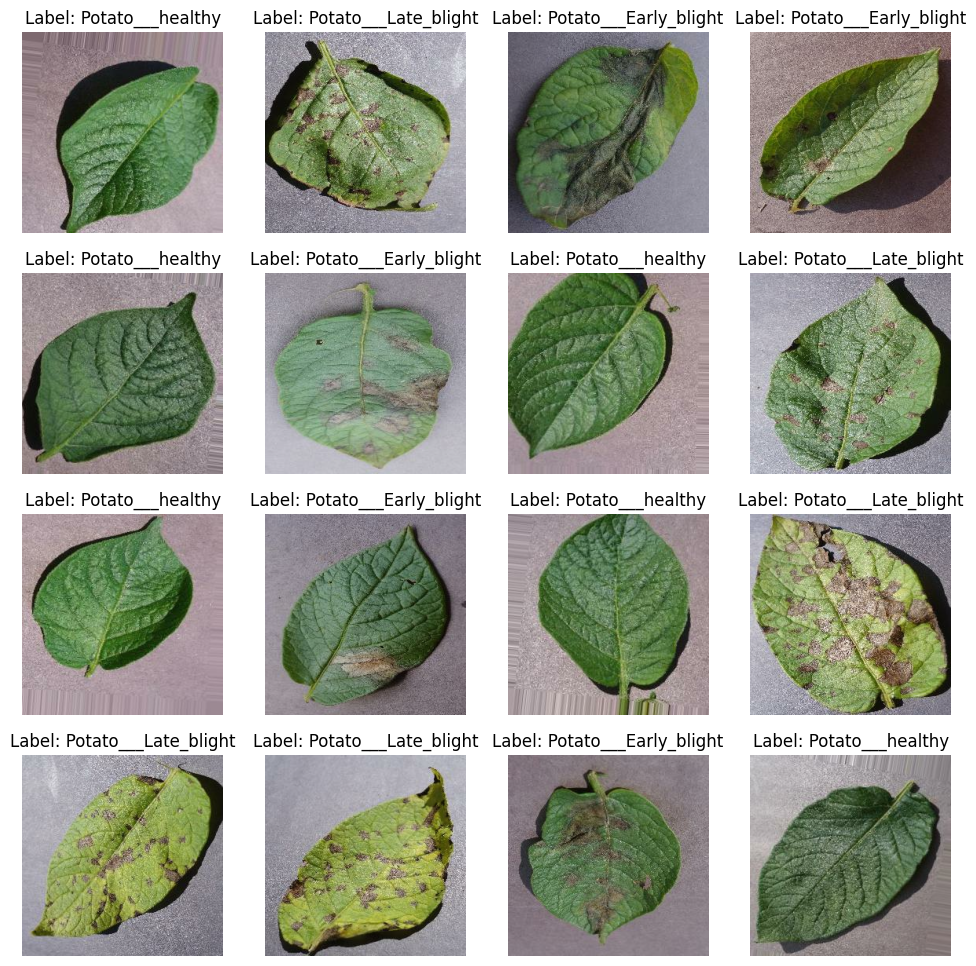

In [20]:
def plot_images(images, labels, class_names):
    plt.figure(figsize=(12, 12))
    for i in range(len(images)):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {class_names[labels[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize a batch of images
for images_batch, labels_batch in augmented_train_dataset.take(1):
    plot_images(images_batch.numpy(), labels_batch.numpy(), class_names)


In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

def create_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

input_shape = (256, 256, 3)
num_classes = len(class_names)
model = create_model(input_shape, num_classes)

# Compile the model with Adam optimizer and learning rate scheduler
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 125, 125, 64)      256       
 chNormalization)                                                
                                                        

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/Potato/Train',
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse'
)

val_generator = val_datagen.flow_from_directory(
    '/content/Potato/Valid',
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse'
)


Found 900 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def create_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

input_shape = (256, 256, 3)
num_classes = len(class_names)
model = create_model(input_shape, num_classes)

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[checkpoint, early_stopping]
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 125, 125, 64)      256       
 chNormalization)                                                
                                                        

ModuleNotFoundError: No module named 'streamlit'